Ref: https://medium.com/searce/tips-tricks-for-using-google-vision-api-for-text-detection-2d6d1e0c6361

In [ ]:
!pip3 install --upgrade pip
!pip3 install --upgrade google-cloud-vision
!pip3 install --upgrade google-cloud-storage

In [1]:
import io
from enum import Enum
from PIL import Image, ImageDraw

In [2]:
path = './sample_img_files/text_detection_image_demo.png'

In [3]:
from google.cloud import vision
client = vision.ImageAnnotatorClient()

with io.open(path, 'rb') as image_file:
    content = image_file.read()

image = vision.types.Image(content=content)

response = client.document_text_detection(image=image)
document = response.full_text_annotation

## Document Text Exploration

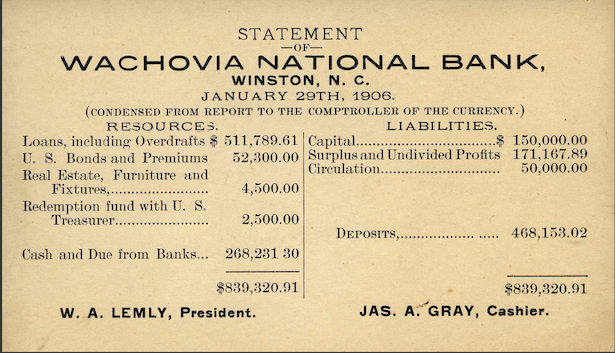

In [4]:
image = Image.open(path)
image

In [5]:
class FeatureType(Enum):
    PAGE = 1
    BLOCK = 2
    PARA = 3
    WORD = 4
    SYMBOL = 5

In [43]:
for page in response.full_text_annotation.pages:
    for block in page.blocks:
        print('\nBlock confidence: {}\n'.format(block.confidence))

        for paragraph in block.paragraphs:
            print('Paragraph confidence: {}'.format(
                paragraph.confidence))

            for word in paragraph.words:
                word_text = ''.join([
                    symbol.text for symbol in word.symbols
                ])
                print('Word text: {} (confidence: {})'.format(
                    word_text, word.confidence))

                for symbol in word.symbols:
                    print('\tSymbol: {} (confidence: {})'.format(
                        symbol.text, symbol.confidence))


Block confidence: 0.5199999809265137

Paragraph confidence: 0.5199999809265137
Word text: - (confidence: 0.550000011920929)
	Symbol: - (confidence: 0.550000011920929)
Word text: OF (confidence: 0.5099999904632568)
	Symbol: O (confidence: 0.8600000143051147)
	Symbol: F (confidence: 0.17000000178813934)

Block confidence: 0.9599999785423279

Paragraph confidence: 0.9800000190734863
Word text: STATEMENT (confidence: 0.9900000095367432)
	Symbol: S (confidence: 0.9900000095367432)
	Symbol: T (confidence: 0.9900000095367432)
	Symbol: A (confidence: 1.0)
	Symbol: T (confidence: 1.0)
	Symbol: E (confidence: 0.9900000095367432)
	Symbol: M (confidence: 0.9900000095367432)
	Symbol: E (confidence: 1.0)
	Symbol: N (confidence: 1.0)
	Symbol: T (confidence: 1.0)
Word text: WACHOVIA (confidence: 0.9900000095367432)
	Symbol: W (confidence: 0.9900000095367432)
	Symbol: A (confidence: 0.9900000095367432)
	Symbol: C (confidence: 0.9900000095367432)
	Symbol: H (confidence: 0.9900000095367432)
	Symbol: O (

In [7]:
def draw_boxes(image, bounds, color, width=1):
    """Draw a border around the image using the hints in the vector list."""
    draw = ImageDraw.Draw(image)
    for bound in bounds:
        draw.line([
            bound.vertices[0].x, bound.vertices[0].y,
            bound.vertices[1].x, bound.vertices[1].y,
            bound.vertices[2].x, bound.vertices[2].y,
            bound.vertices[3].x, bound.vertices[3].y,
            bound.vertices[0].x, bound.vertices[0].y], fill=color, width=width)
    return image

In [8]:
def get_document_bounds(response, feature):
    """Returns document bounds given an image."""
    bounds = []
    
    # Collect specified feature bounds by enumerating all document features
    for i, page in enumerate(document.pages):
        for block in page.blocks:
            for paragraph in block.paragraphs:
                for word in paragraph.words:
                    for symbol in word.symbols:
                        if (feature == FeatureType.SYMBOL):
                            bounds.append(symbol.bounding_box)

                    if (feature == FeatureType.WORD):
                        bounds.append(word.bounding_box)

                if (feature == FeatureType.PARA):
                    bounds.append(paragraph.bounding_box)

            if (feature == FeatureType.BLOCK):
                bounds.append(block.bounding_box)

        if (feature == FeatureType.PAGE):
            bounds.append(block.bounding_box)
            
    # The list `bounds` contains the coordinates of the bounding boxes.
    return bounds

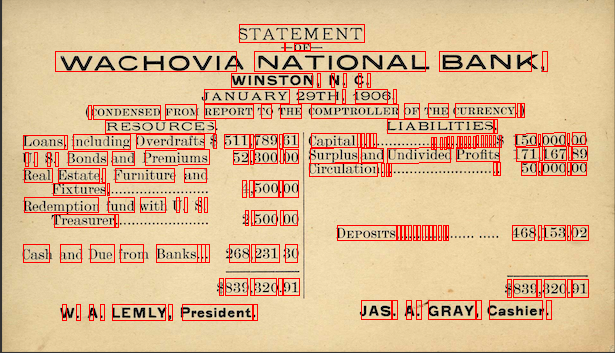

In [9]:
image = Image.open(path)
bounds = get_document_bounds(response, FeatureType.WORD)
draw_boxes(image, bounds, 'red')

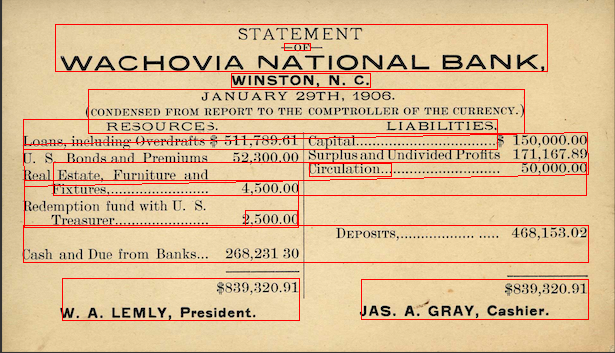

In [10]:
image = Image.open(path)
bounds = get_document_bounds(response, FeatureType.PARA)
draw_boxes(image, bounds, 'red')

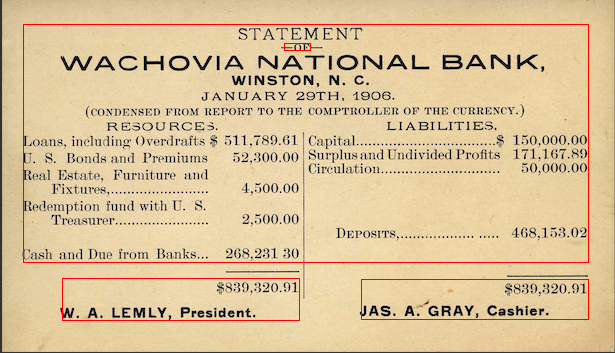

In [11]:
image = Image.open(path)
bounds = get_document_bounds(response, FeatureType.BLOCK)
draw_boxes(image, bounds, 'red')

## Finding location of a word

In [12]:
def assemble_word(word):
    assembled_word=""
    for symbol in word.symbols:
        assembled_word += symbol.text
    return assembled_word

def find_word_location(document,word_to_find):
    for page in document.pages:
        for block in page.blocks:
            for paragraph in block.paragraphs:
                for word in paragraph.words:
                    assembled_word = assemble_word(word)
                    if(assembled_word==word_to_find):
                        return word.bounding_box

In [13]:
location = find_word_location(document, 'Overdrafts')
location

vertices {
  x: 136
  y: 134
}
vertices {
  x: 204
  y: 134
}
vertices {
  x: 204
  y: 148
}
vertices {
  x: 136
  y: 148
}

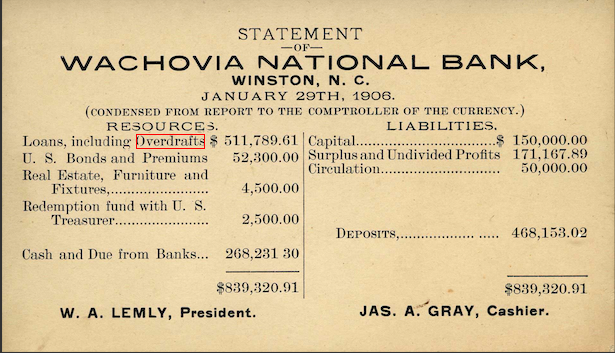

In [14]:
image = Image.open(path)
draw_boxes(image, [location], 'Red')

## Finding word inside a given bounding coordinates

In [15]:
def text_within(document, x1, y1, x2, y2):
    text = ""
    for page in document.pages:
        for block in page.blocks:
            for paragraph in block.paragraphs:
                for word in paragraph.words:
                    for symbol in word.symbols:
                        min_x = min(symbol.bounding_box.vertices[0].x, symbol.bounding_box.vertices[1].x, symbol.bounding_box.vertices[2].x, symbol.bounding_box.vertices[3].x)
                        max_x = max(symbol.bounding_box.vertices[0].x, symbol.bounding_box.vertices[1].x, symbol.bounding_box.vertices[2].x, symbol.bounding_box.vertices[3].x)
                        min_y = min(symbol.bounding_box.vertices[0].y, symbol.bounding_box.vertices[1].y, symbol.bounding_box.vertices[2].y, symbol.bounding_box.vertices[3].y)
                        max_y = max(symbol.bounding_box.vertices[0].y, symbol.bounding_box.vertices[1].y, symbol.bounding_box.vertices[2].y, symbol.bounding_box.vertices[3].y)
                        if(min_x >= x1 and max_x <= x2 and min_y >= y1 and max_y <= y2):
                            text+=symbol.text
                            if(symbol.property.detected_break.type==1 or symbol.property.detected_break.type==3):
                                text+=' '
                            if(symbol.property.detected_break.type==2):
                                text+='\t'
                            if(symbol.property.detected_break.type==5):
                                text+='\n'
    return text

In [16]:
text_within(document, 
            location.vertices[1].x,
            location.vertices[1].y-1,
            30+location.vertices[1].x+(location.vertices[1].x-location.vertices[0].x),
            location.vertices[2].y)

'$ 511,789.61 '

## TEST - Finding word inside a given bounding coordinates

In [42]:
# Test drawing line
def draw_line(image, x1, y1, x2, y2, color, width=1):
    draw = ImageDraw.Draw(image)
    draw.line([
        x1, y1,
        x2, y2,
        x1, y1], fill=color, width=width)
    return image

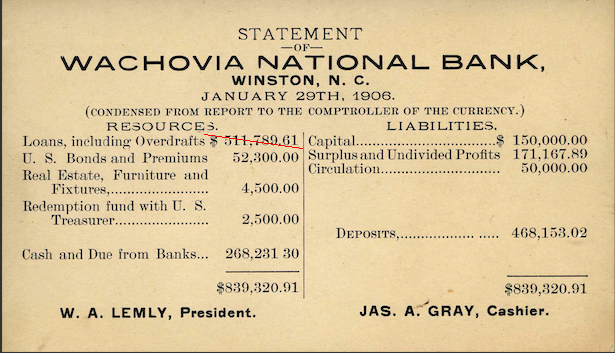

In [18]:
image = Image.open(path)
draw_line(image,
          location.vertices[1].x,
          location.vertices[1].y,
          30+location.vertices[1].x+(location.vertices[1].x-location.vertices[0].x),
          location.vertices[2].y,
          'red')

## Finding next word until the next line

In [36]:
def text_next(document, x_start, y_start, x_end):
    text = ""
    for page in document.pages:
        for block in page.blocks:
            for paragraph in block.paragraphs:
                for word in paragraph.words:
                    for symbol in word.symbols:
                        min_x = min(symbol.bounding_box.vertices[0].x, symbol.bounding_box.vertices[1].x, symbol.bounding_box.vertices[2].x, symbol.bounding_box.vertices[3].x)
                        max_x = max(symbol.bounding_box.vertices[0].x, symbol.bounding_box.vertices[1].x, symbol.bounding_box.vertices[2].x, symbol.bounding_box.vertices[3].x)
                        min_y = min(symbol.bounding_box.vertices[0].y, symbol.bounding_box.vertices[1].y, symbol.bounding_box.vertices[2].y, symbol.bounding_box.vertices[3].y)
                        max_y = max(symbol.bounding_box.vertices[0].y, symbol.bounding_box.vertices[1].y, symbol.bounding_box.vertices[2].y, symbol.bounding_box.vertices[3].y)
                        if(min_x >= x_start and max_x <= x_end and min_y <= y_start and max_y >= y_start):
                            text+=symbol.text
                            if(symbol.property.detected_break.type==1 or symbol.property.detected_break.type==3):
                                text+=' '
                            if(symbol.property.detected_break.type==2):
                                text+='\t'
                            if(symbol.property.detected_break.type==5):
                                text+='\n'
    return text

In [41]:
x_start = location.vertices[1].x
y_start = int(location.vertices[1].y+((location.vertices[3].y-location.vertices[0].y)/2))
x_end = location.vertices[1].x+100
y_end = int(location.vertices[1].y+((location.vertices[3].y-location.vertices[0].y)/2))
# print(x_start)
# print(y_start)
# print(x_end)
# print(y_end)

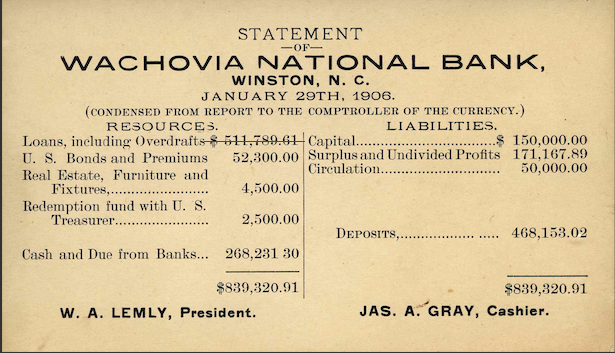

In [39]:
image = Image.open(path)
draw_line(image, x_start, y_start, x_end, y_end, 'red')

In [40]:
text_next(document, x_start, y_start, x_end)

'$ 511,789.61 '